In [1]:
from hex.graph_hex_board import GraphHexBoard
import numpy as np
from matplotlib.cm import ScalarMappable

class GHB(GraphHexBoard):
    @property
    def cell_colours(self):
        sm = ScalarMappable(cmap='viridis')
        return sm.to_rgba(self.x)

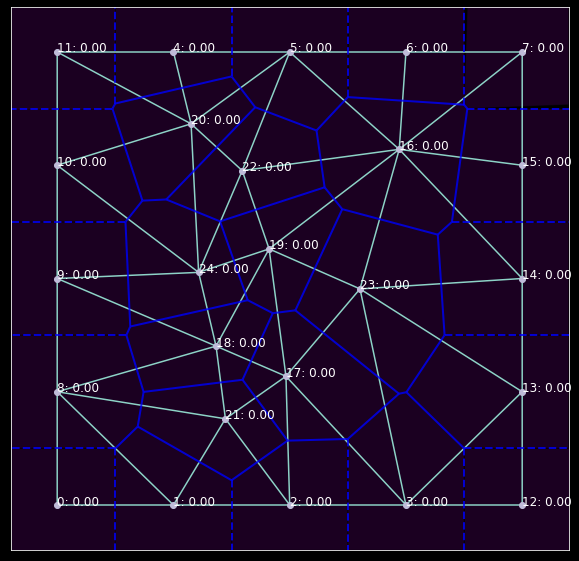

In [2]:
import torch
from torch_geometric.utils import get_laplacian

board = GHB.new_vortex_board(5)
#board.add_stone(15, -1)
board.x = torch.zeros_like(board.node_attr[:,0])
board.x[-1] = 1.
board.plot()
L = get_laplacian(board.edge_index, normalization='sym')
L = torch.sparse_coo_tensor(L[0], L[1])

In [3]:
board.x = torch.zeros_like(board.node_attr[:,0])
board.x[-1] = 1.
d = 10
steps = []
for i in range(d):
    steps.append(board.x.clone().detach())
    if i < d-1:
        board.x = L @ board.x
x = torch.stack(steps)
x.shape

torch.Size([10, 29])

In [8]:

from torch.utils.data import Dataset, TensorDataset

def sample(ns=5, d=10):
    l_side = ns**2 + 2
    board = GHB.new_vortex_board(ns)
    L = get_laplacian(board.edge_index, normalization='sym')
    L = torch.sparse_coo_tensor(L[0], L[1])
    A = torch.sparse_coo_tensor(board.edge_index, torch.ones_like(board.edge_index[0]), dtype=torch.float)

    # labels
    y = torch.zeros_like(board.node_attr[:,0])
    y[l_side] = 1.
    m = board.edge_index[0] == l_side
    one_hop = board.edge_index[1, m]
    y = A @ (A @ y)
    y[l_side] = 0.
    y[one_hop] = 0.
    y = (y >= 2.).to(torch.float)

    # features
    x = torch.zeros_like(board.node_attr[:,0])
    x[l_side] = 1.
    steps = []
    for i in range(d):
        steps.append(x.clone().detach())
        if i < d-1:
            x = L @ x
    x = torch.stack(steps, dim=1)
    
    return x, y

class TwoBridge_DS(TensorDataset):
    def __init__(self, sample_boards=1000, nsides=5, dim=10):   
        self.sample_boards = sample_boards
        self.nsides = nsides
        self.dim = dim

        x, y = [], []

        for i in range(sample_boards):
            xs, ys = sample(nsides, dim)
            x.append(xs)
            y.append(ys)

        x = torch.cat(x, dim=0)
        y = torch.cat(y, dim=0).unsqueeze(1)
        super().__init__(x, y)


In [9]:
nsides=5
dim=10

train_ds = TwoBridge_DS(sample_boards=1000, nsides=nsides, dim=dim)
val_ds = TwoBridge_DS(sample_boards=100, nsides=nsides, dim=dim)


In [3]:
class AverageMeter(object):
    def __init__(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def __repr__(self):
        return f'{self.avg:.2e}'

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
from torch.nn import Linear, BCEWithLogitsLoss
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Linear(dim, 1).to(device)
criterion = BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

for epoch in range(EPOCHS):
    train_loss = AverageMeter()
    val_loss = AverageMeter()
    val_accuracy = AverageMeter()
    print("Epoch {}".format(epoch))

    model.train()
    for x, y in train_dl:
        x, y = x.to(device=device), y.to(device=device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.update(loss.item())
    
    print("\ttrain - loss: {}".format(train_loss))

    model.eval()
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device=device), y.to(device=device)
            out = model(x)
            loss = criterion(out, y)
            val_loss.update(loss.item())
            val_accuracy.update(roc_auc_score(y.cpu().numpy(), out.cpu().numpy()))

    print("\tval - loss: {}, accuracy: {:.2f}%".format(val_loss.avg, val_accuracy.avg*100))

Epoch 0
	train - loss: 5.50e-01
	val - loss: 0.4727834612131119, accuracy: 93.60%
Epoch 1
	train - loss: 4.20e-01
	val - loss: 0.37330092100993445, accuracy: 95.92%
Epoch 2
	train - loss: 3.41e-01
	val - loss: 0.31076145560845087, accuracy: 96.66%
Epoch 3
	train - loss: 2.90e-01
	val - loss: 0.2691678518186445, accuracy: 96.83%
Epoch 4
	train - loss: 2.55e-01
	val - loss: 0.24001000853984253, accuracy: 96.87%
Epoch 5
	train - loss: 2.30e-01
	val - loss: 0.21861395498980646, accuracy: 96.96%
Epoch 6
	train - loss: 2.12e-01
	val - loss: 0.20232849924460702, accuracy: 97.01%
Epoch 7
	train - loss: 1.97e-01
	val - loss: 0.1895239066494548, accuracy: 97.02%
Epoch 8
	train - loss: 1.86e-01
	val - loss: 0.17920499813297522, accuracy: 97.04%
Epoch 9
	train - loss: 1.76e-01
	val - loss: 0.17069996439892313, accuracy: 97.09%
Epoch 10
	train - loss: 1.69e-01
	val - loss: 0.1635412170511225, accuracy: 97.13%
Epoch 11
	train - loss: 1.62e-01
	val - loss: 0.1573938335413518, accuracy: 97.17%
Epoch 1

Testing at different board scales

In [25]:
xs, ys = sample(17, 10)
xs, ys = xs.to(device), ys.to(device)

with torch.no_grad():
    out = model(xs)

roc_auc_score(ys.cpu().numpy(), out.cpu().numpy())

1.0

Detect independant two bridge side connections

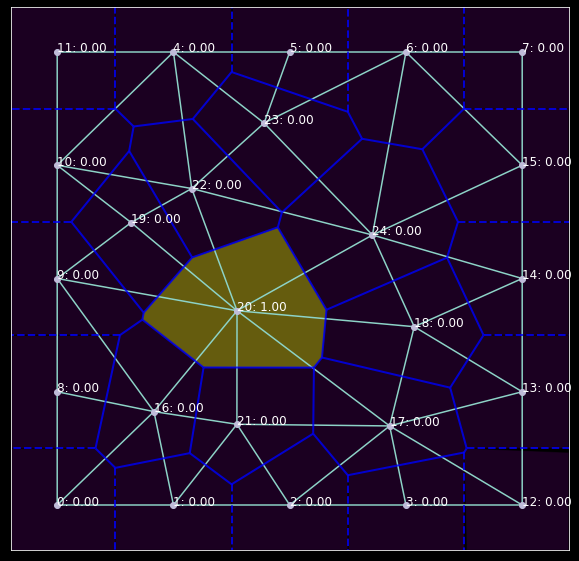

In [4]:
from itertools import combinations, product

def secure_2hop(n_nodes, A, edge_index, side_n):
    # label the secure 2 hop faces
    y = torch.zeros(n_nodes)
    y[side_n] = 1.
    m = edge_index[0] == side_n
    one_hop = board.edge_index[1, m]
    y = A @ (A @ y)
    y[side_n] = 0.
    y[one_hop] = 0.

    return (y >= 2.).nonzero().squeeze().tolist()

def independent_s2h_pairs(s_2hop, edge_index, side_n):
    # get the side connection sets for each 2-hop side connections
    csets = {}
    for n in s_2hop:
        a = set(edge_index[1, edge_index[0] == n].tolist())
        b = set(edge_index[1, edge_index[0] == side_n].tolist())
        csets[n] = a & b

    pset = combinations(s_2hop, 2)

    #find independent pairs of secure 2-hop side connections 
    i2hsc = []
    for s in pset:
        a, b = csets[s[0]], csets[s[1]]
        ndups = len(a & b)
        if (len(a) + len(b) - ndups) >= 4:
            i2hsc.append(s)
    
    return i2hsc

def find_winner(ns):
    n_nodes = ns**2 + 4
    l_side = n_nodes - 2
    r_side = n_nodes - 1
    # setup the board
    board = GHB.new_vortex_board(ns)
    A = torch.sparse_coo_tensor(board.edge_index, torch.ones_like(board.edge_index[0]), dtype=torch.float)
    edge_index = board.edge_index

    board.x = torch.zeros(n_nodes)
    ls_2hop = secure_2hop(n_nodes, A, edge_index, l_side)
    rs_2hop = secure_2hop(n_nodes, A, edge_index, r_side)
    board.x[ls_2hop + rs_2hop] = 1.

    lsp = independent_s2h_pairs(ls_2hop, edge_index, l_side)
    rsp = independent_s2h_pairs(rs_2hop, edge_index, r_side)
    opp_pairs = product(lsp, rsp)

    def connectors(A, ndx):
        return (A.to_dense()[ndx].sum(dim=0) == len(ndx)).nonzero().squeeze()

    for scn in opp_pairs:
        ndx = list(scn[0]) + list(scn[1])
        cn = connectors(A, ndx)
        if cn.numel() == 1:
            return board, cn.item()

    return None


ns = 5
res = None
while(res is None):
    res = find_winner(ns)

board, n = res
board.x = torch.zeros_like(board.node_attr[:,0])
board.x[n] = 1.
board.plot()    

Win in 8 moves DataSet

In [6]:
from torch.utils.data import TensorDataset

def wi8_features(ns, edge_index, dim):    
    n_nodes = ns**2 + 4
    l_side = n_nodes - 2
    r_side = n_nodes - 1

    L = get_laplacian(edge_index, normalization='sym')
    L = torch.sparse_coo_tensor(L[0], L[1])

    # features
    n_steps = dim // 2
    steps = []

    x = torch.zeros_like(board.node_attr[:,0])
    x[l_side] = 1.
    for i in range(n_steps):
        steps.append(x.clone().detach())
        if i < n_steps-1:
            x = L @ x

    x = torch.zeros_like(board.node_attr[:,0])
    x[r_side] = 1.
    for i in range(n_steps):
        steps.append(x.clone().detach())
        if i < n_steps-1:
            x = L @ x

    x = torch.stack(steps, dim=1)
    
    return x

def get_wi8(ns):   
    res = None
    while(res is None):
        res = find_winner(ns)
    return res 

class WI8_DS(TensorDataset):
    def __init__(self, sample_boards=1000, nsides=5, dim=20):   
        self.sample_boards = sample_boards
        self.nsides = nsides
        self.dim = dim

        x, y = [], []

        for i in range(sample_boards):
            board, n = get_wi8(nsides)
            xs = wi8_features(nsides, board.edge_index, dim)
            x.append(xs)
            y.append(n)

        x = torch.stack(x, dim=0)
        y = torch.tensor(y, dtype=torch.long)
        super().__init__(x, y)

Generate data

In [7]:
nsides=5
dim=20

train_ds = WI8_DS(sample_boards=2000, nsides=nsides, dim=dim)
val_ds = WI8_DS(sample_boards=200, nsides=nsides, dim=dim)

Model

In [8]:
from torch.nn import Linear, Module, LogSoftmax, Softmax

class VorNet_Linear(Module):
    """
    top-1 accuracy 74.48% on 25 node board
    """
    def __init__(self, in_features=20):
        super().__init__()
        self.lin = Linear(in_features=in_features, out_features=1)
        self.train_readout = LogSoftmax(dim=1)
        self.readout = Softmax(dim=1)

    def forward(self, x):
        B, N, F = x.shape

        x = x.view(B*N, F)
        out = self.lin(x)
        out = out.view(B, N)
        readout = self.train_readout if self.training else self.readout
        out = readout(out)

        return out

class VorNet_MLP(Module):
    """
    top-1 accuracy 74.48% on 25 node board
    """
    def __init__(self, in_features=20):
        super().__init__()
        self.lin1 = Linear(in_features=in_features, out_features=64)
        self.lin2 = Linear(in_features=64, out_features=1)
        self.train_readout = LogSoftmax(dim=1)
        self.readout = Softmax(dim=1)

    def forward(self, x):
        B, N, F = x.shape

        x = x.view(B*N, F)
        x = self.lin1(x)
        x = x.relu()
        out = self.lin2(x)
        
        out = out.view(B, N)
        readout = self.train_readout if self.training else self.readout
        out = readout(out)

        return out

Train

In [9]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VorNet_MLP().to(device)

In [10]:

from torch.utils.data import DataLoader
from torch.nn import NLLLoss
from sklearn.metrics import top_k_accuracy_score

LR = 1e-4
EPOCHS = 10000
BATCH_SIZE = 64

criterion = NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

for epoch in range(EPOCHS):
    train_loss = AverageMeter()
    val_loss = AverageMeter()
    val_accuracy = AverageMeter()
    print("Epoch {}".format(epoch))

    model.train()
    for x, y in train_dl:
        x, y = x.to(device=device), y.to(device=device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.update(loss.item())
    
    print("\ttrain - loss: {}".format(train_loss))

    model.eval()
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device=device), y.to(device=device)
            out = model(x)
            loss = criterion(out, y)
            val_loss.update(loss.item())
            val_accuracy.update(top_k_accuracy_score(y.cpu().numpy(), out.squeeze().cpu().numpy(), k=1, labels=np.arange(29)))

    print("\tval - loss: {}, accuracy: {:.2f}%".format(val_loss.avg, val_accuracy.avg*100))

Epoch 0
	train - loss: 3.33e+00
	val - loss: -0.03767773136496544, accuracy: 0.00%
Epoch 1
	train - loss: 3.25e+00
	val - loss: -0.04063090495765209, accuracy: 0.00%
Epoch 2
	train - loss: 3.18e+00
	val - loss: -0.04348934628069401, accuracy: 0.00%
Epoch 3
	train - loss: 3.11e+00
	val - loss: -0.04632450547069311, accuracy: 17.58%
Epoch 4
	train - loss: 3.05e+00
	val - loss: -0.04926757235080004, accuracy: 17.97%
Epoch 5
	train - loss: 2.99e+00
	val - loss: -0.05234512593597174, accuracy: 17.97%
Epoch 6
	train - loss: 2.93e+00
	val - loss: -0.05555359832942486, accuracy: 18.75%
Epoch 7
	train - loss: 2.87e+00
	val - loss: -0.05890943016856909, accuracy: 17.97%
Epoch 8
	train - loss: 2.82e+00
	val - loss: -0.06248228903859854, accuracy: 21.48%
Epoch 9
	train - loss: 2.76e+00
	val - loss: -0.06625504419207573, accuracy: 21.48%
Epoch 10
	train - loss: 2.71e+00
	val - loss: -0.07019052840769291, accuracy: 21.48%
Epoch 11
	train - loss: 2.65e+00
	val - loss: -0.07432596385478973, accuracy: 

In [11]:
x, y = val_ds[0]

y_pred = model(x.unsqueeze(0).to(device))

y_pred, y_pred.argmax(), y

(tensor([[1.5414e-44, 1.3027e-04, 4.8354e-04, 1.4960e-08, 1.9059e-04, 9.5680e-05,
          1.8599e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.6052e-45,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7863e-32, 4.8881e-10,
          2.9193e-26, 2.0187e-03, 1.3861e-03, 9.9569e-01, 1.1743e-24, 1.9271e-33,
          1.3930e-08, 1.5481e-36, 9.8008e-36, 0.0000e+00, 0.0000e+00]],
        device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(21, device='cuda:0'),
 tensor(21))

In [1]:
64*28

1792

In [6]:
import numpy as np

A = np.array([[1,0],[1,1]])

A, A@A, A@A@A

(array([[1, 0],
        [1, 1]]),
 array([[1, 0],
        [2, 1]]),
 array([[1, 0],
        [3, 1]]))

In [36]:
w, v = np.linalg.eig(A)
A, w, v, np.linalg.det(A)

(array([[1, 0],
        [1, 1]]),
 array([1., 1.]),
 array([[ 0.00000000e+00,  2.22044605e-16],
        [ 1.00000000e+00, -1.00000000e+00]]),
 1.0)

In [35]:
A@np.array([0,1])

array([0, 1])

In [20]:
from math import sqrt

IB = np.array([[2,1+sqrt(5)],[2,1-sqrt(5)]]).T
w, IB = np.linalg.eig(A)
IB, np.linalg.inv(IB)

(array([[ 2.        ,  2.        ],
        [ 3.23606798, -1.23606798]]),
 array([[ 0.1381966,  0.2236068],
        [ 0.3618034, -0.2236068]]))

In [78]:
from numpy import linalg as la

A_1 = np.array([[0,1],[1,1]])
#Eb = np.array([[2,1+sqrt(5)],[2,1-sqrt(5)]]).T
w, Eb = np.linalg.eig(A_1)
#Eb = Eb[:,[1,0]]
Eb_inv = la.inv(Eb)

A_1, Eb, Eb_inv

(array([[0, 1],
        [1, 1]]),
 array([[-0.85065081, -0.52573111],
        [ 0.52573111, -0.85065081]]),
 array([[-0.85065081,  0.52573111],
        [-0.52573111, -0.85065081]]))

In [88]:
A_t = np.diagonal((Eb_inv @ A_1 @ Eb))
A_t**20

array([6.61069614e-05, 1.51269999e+04])

In [76]:
A_1 = np.array([[3,1],[0,2]])
w, Eb = np.linalg.eig(A_1)
#Eb = Eb[:,[1,0]]
Eb_inv = la.inv(Eb)

A_1, Eb, Eb_inv

(array([[3, 1],
        [0, 2]]),
 array([[ 1.        , -0.70710678],
        [ 0.        ,  0.70710678]]),
 array([[1.        , 1.        ],
        [0.        , 1.41421356]]))

In [77]:
Eb_inv @ A_1 @ Eb

array([[3., 0.],
       [0., 2.]])

In [96]:
A = np.concatenate([np.ones((5, 1)), np.zeros((5, 4))], axis=1)
np.linalg.eig(A)

(array([0., 0., 0., 0., 1.]),
 array([[0.       , 0.       , 0.       , 0.       , 0.4472136],
        [0.       , 1.       , 0.       , 0.       , 0.4472136],
        [0.       , 0.       , 1.       , 0.       , 0.4472136],
        [0.       , 0.       , 0.       , 1.       , 0.4472136],
        [1.       , 0.       , 0.       , 0.       , 0.4472136]]))

In [127]:
A = np.array([[1,0],[0,1]])
np.linalg.eig(A)

(array([1., 1.]),
 array([[1., 0.],
        [0., 1.]]))

In [119]:
x, y = np.meshgrid(np.arange(10), np.arange(10))
M1 = (x+y)/2
M2 = (x*y)**0.5

M1, M2


(array([[0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5],
        [0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ],
        [1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5],
        [1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ],
        [2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5],
        [2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ],
        [3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5],
        [3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ],
        [4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5],
        [4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. ]]),
 array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 1.41421356, 1.73205081, 2.        ,
         2.23606798, 2.44948974, 2.64575131, 2.82842712, 3.        ],
        [0.        , 1.41421356, 2.        , 2.44948974, 2.82842712,
         3.16227766, 3.46410162, 3.74165739, 4.    

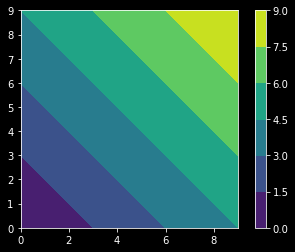

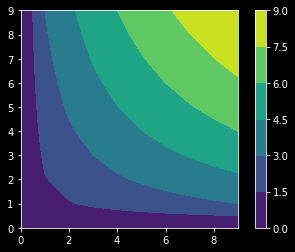

In [121]:
import matplotlib.pyplot as plt
h = plt.contourf(x, y, M1)
plt.axis('scaled')
plt.colorbar()
plt.show()

h = plt.contourf(x, y, M2)
plt.axis('scaled')
plt.colorbar()
plt.show()

Text(0.5, 0.92, 'surface')

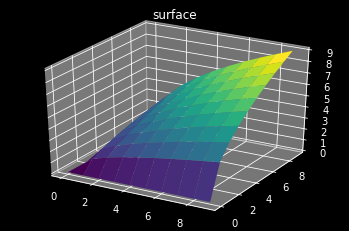

In [126]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, M2, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface')